# **Intro**
In this notebook I set up conditional semi-supervised VAE that attempts to predict the proportions of MNIST numbers that have been superimposed on top of one another.

This is similar to the DIVA, where we use the rotation as labels and instead of having partially labeled numbers, we will have partially labeled number proportions. 
In that setup some labels are ommited to make it semi-supervised, which we will also do.
This will mimic the idea that we have bulk case vs. control examples (we don't know the proportions) and  simulate bulk samples from single-cell profiles, (where we don't have treatment data).
Using both of these sources of data we hope that we can work in OOD stuff.
Also, we use the M1+M2 formulation of semi-supervised as described here: "Semi-supervised Learning with Deep Generative Models", https://arxiv.org/abs/1406.5298

The difference in this model are the following: 


1.   We are learning proportions of numbers in an image, not a specific number.
This means that this is regression, not classification.
2.   We put the constraint directly on mu, not on an external classifier.
This is because we want to be able to augment mu and reconstruct in a logical manner.
For example, we want to be able to simulate the mixture of specific cell types by augmenting mu.
3.   We add in an additional classification loss for classification of treated vs. untreated.
We hope that by learning two separate processes (stack proportions and case/control classification) we will have enough information to compose them and handle out-of-distribution responses.
This did not work when we simply used the treatment as a condition, instead we will need to have a downstream classifier, linked to z, that will predict treatment status.



A lot of the model code was taken from this tutorial: https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb

And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/




# **Github / VM setup**

To integrate Colab with github, we need to do some setup first.
If you want this to integrate with your own github repo, you will need to create a `secrets` folder that contain your public and private key, and register this to access you github repo. Check `setup.sh` for more details.

In [2]:
import os, sys

NB_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood'
sys.path.append('/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood')

In [3]:
# prelude: set up git, etc.
%cd {NB_ROOT_PATH}
!( source setup.sh )

/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood
Ensuring ssh keys exist...
Copied key(s) to /root/.ssh/
total 12
-rw-r--r-- 1 root root  43 Aug 18 04:54 config
-rw------- 1 root root 432 Aug 18 04:54 id_rsa
-rw-r--r-- 1 root root 113 Aug 18 04:54 id_rsa.pub


In [4]:
%%bash
# do your git operations here
git add .
git commit -m "new experi"
git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   experiments/DIVA_stacked_mnist.ipynb
	modified:   experiments/ssDIVA_stacked_mnist.ipynb
	modified:   experiments/stacked_conditional_ssVAE_mnist.ipynb
	modified:   experiments/stepwise_ssDIVA_stacked_mnist.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	experiments/rotated_example_ssDIVA_mnist.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


# **Imports**

In [5]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from sklearn.manifold import TSNE

# programming stuff
import time
import os
import pickle
from pathlib import Path

# Load the TensorBoard notebook extension
%load_ext tensorboard

# load methods from other files
from mnist_preprocessing import generate_data as gd

# I disable eager execution ... forgot why
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# **Load / Pre-process data**
Import + reshape the non-rotated MNIST data

In [6]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
Y_train = to_categorical(Y_train)

print(X_train.shape)
print(X_test.shape)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

print(Y_train)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


Import + reshape and rotate MNIST data.
In our single-cell analogy, rotation is a treatment and the number value is a cell-type.

In [7]:
(X_train_r, Y_train_r), (X_test_r, Y_test_r) = mnist.load_data()
Y_train_r = to_categorical(Y_train_r)
# now add in the rotation
def rotate_90(img):
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

def rotate_deg(in_img, angle):
  img = Image.fromarray(np.uint8(in_img) , 'L')
  img = img.rotate(angle)
  return np.asarray(img)

def rotate_data(X_train, Y_train, X_test, Y_test, angle):
  # rotate the training data
  X_train_15 = np.array([rotate_deg(xi, angle) for xi in X_train_r])
  Y_train_15 = Y_train

  # rotate the test data
  X_test_15 = np.array([rotate_90(xi) for xi in X_test_r])
  Y_test_15 = Y_test

  # reshape the data
  X_train_15 = X_train_15.astype('float32') / 255.
  X_test_15 = X_test_15.astype('float32') / 255.

  n_pixels = np.prod(X_train_15.shape[1:])
  X_train_15 = X_train_15.reshape((len(X_train_15), n_pixels))
  X_test_15 = X_test_15.reshape((len(X_test_15), n_pixels))

  return (X_train_15, Y_train_15, X_test_15, Y_test_15)

X_train_15, Y_train_15, X_test_15, Y_test_15 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 15)
X_train_30, Y_train_30, X_test_30, Y_test_30 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 30)
X_train_45, Y_train_45, X_test_45, Y_test_45 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 45)
X_train_60, Y_train_60, X_test_60, Y_test_60 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 60)
X_train_75, Y_train_75, X_test_75, Y_test_75 = rotate_data(X_train_r, Y_train_r, 
                                                           X_test_r, Y_test_r, 
                                                           angle = 75)



Demo the data, to make sure everything works

rotated 15


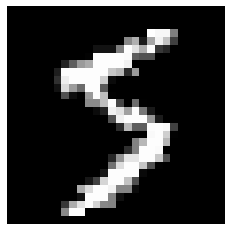

rotated 30


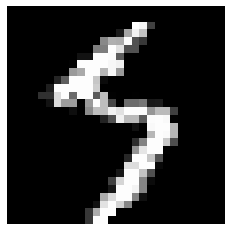

rotated 45


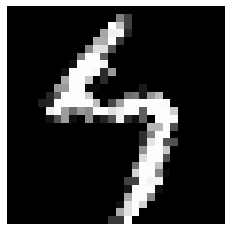

rotated 60


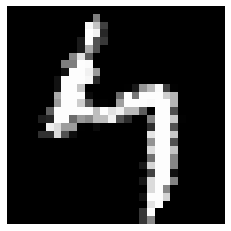

rotated 75


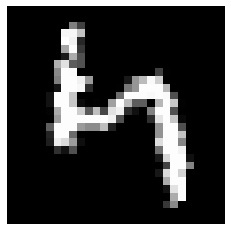

In [8]:
print("rotated 15")
plt.imshow(X_train_15[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 30")
plt.imshow(X_train_30[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 45")
plt.imshow(X_train_45[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 60")
plt.imshow(X_train_60[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 75")
plt.imshow(X_train_75[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

# **Model Definition**


## Hyperparameters

In [9]:
run_prop_sampler = False

batch_size = 500
n_epoch = 75

alpha_rot = 1000000
alpha_prop = 100 ###

beta_kl_slack = 10
beta_kl_rot = 100
beta_kl_prop = 10

# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = 10 # latent space size, one latent dimension PER MNIST digit
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of encoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer

activ = 'relu'
optim = Adam(learning_rate=0.001)

n_x = X_train.shape[1]
n_y = Y_train.shape[1]
n_label = 6
n_label_z = 64

print(f"length of X {n_x} and length of y {n_y} and n_label {n_label}")



length of X 784 and length of y 10 and n_label 6


## Encoder

In [10]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))

# concatenate input with the label 
inputs = X

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_s = Dense(encoder_dim, activation=activ, name="encoder_slack")(inputs)
encoder_p = Dense(encoder_dim, activation=activ, name="encoder_prop")(inputs)
encoder_r = Dense(encoder_dim, activation=activ, name="encoder_rot")(inputs)

# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_z, activation='linear', name = "mu_slack")(encoder_s)
l_sigma_slack = Dense(n_z, activation='linear', name = "sigma_slack")(encoder_s)

mu_prop = Dense(n_z, activation='linear', name = "mu_prop")(encoder_p)
l_sigma_prop = Dense(n_z, activation='linear', name = "sigma_prop")(encoder_p)

mu_rot = Dense(n_label_z, activation='linear', name = "mu_rot")(encoder_r)
l_sigma_rot = Dense(n_label_z, activation='linear', name = "sigma_rot")(encoder_r)


## Latent Space

In [11]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_z])
z_prop = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_prop")([mu_prop, l_sigma_prop, n_z])
z_rot = Lambda(sample_z, output_shape = (n_label, ), name="z_samp_rot")([mu_rot, l_sigma_rot, n_label_z])

z_concat = concat([z_slack, z_prop, z_rot])

## Priors

In [12]:
# prior for the rotation
prior_rot_h1 = Dense(n_label_z, activation=activ, name="prior_h1")(label)
prior_rot_h2 = Dense(n_label_z, activation=activ, name="prior_h2")(prior_rot_h1)

mu_rot_prior = Dense(n_label_z, activation='linear', name = "mu_rot_prior")(prior_rot_h2)
l_sigma_rot_prior = Dense(n_label_z, activation='linear', name = "sigma_rot_prior")(prior_rot_h2)


## Decoder + Classifiers

In [13]:
def null_f(args):
    return args

# set up decoder network
# this is a decoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")

# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

# this is the proportions we try to estimate
decoder_props = Softmax(name = "mu_prop_pred") # ReLU

# this is the rotation we try to estimate
rot_h1 = ReLU(name = "rot_h1")
rot_h2 = Dense(n_label, activation='linear', name = "rot_h2")
rot_props = Softmax(name = "mu_rot_pred")

# we use this to get sigma to do sampling later
decoder_sigma = Lambda(null_f, name = "l_sigma_prop_pred")

# link them together
h_p = decoder_hidden(z_concat)
outputs = decoder_out(h_p)

rot_1_out = rot_h1(z_rot)
rot_2_out = rot_h2(rot_1_out)
rotation_outputs = rot_props(rot_2_out)

prop_outputs = decoder_props(mu_prop)
sigma_outputs = decoder_sigma(l_sigma_prop)


d_in = Input(shape=(n_z+n_z+n_label_z,))
d_h1 = decoder_hidden(d_in)
d_out = decoder_out(d_h1)






## Loss

In [14]:

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl_prop = beta_kl_prop * K.sum(K.exp(l_sigma_prop) + K.square(mu_prop) - 1. - l_sigma_prop, axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_prop + kl_rot + kl_slack

def KL_loss(y_true, y_pred):
	return(beta_kl * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


def prop_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1) * alpha_prop


def prop_loss_unknown(y_true, y_pred):
  total_loss = 0
  for idx in range(0, 100): 
    y_temp = tf.random.shuffle(y_true)
    total_loss = total_loss + K.sum(K.binary_crossentropy(y_temp, y_pred), axis=-1)
  return total_loss / 1.

def class_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)*alpha_rot
    return recon



## Make the computational graph

In [15]:

known_prop_vae = Model(X, [outputs, prop_outputs, rotation_outputs, sigma_outputs])
unknown_prop_vae = Model(X, [outputs, prop_outputs, rotation_outputs])

known_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss, class_loss, None]) #, metrics = [KL_loss, recon_loss])
unknown_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss_unknown, class_loss]) #, metrics = [KL_loss, recon_loss])


encoder = Model(X, [z_slack, mu_prop, z_rot])

decoder = Model(d_in, d_out)

print(known_prop_vae.summary())
print(unknown_prop_vae.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder_slack (Dense)           (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
encoder_prop (Dense)            (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
encoder_rot (Dense)             (None, 512)          401920      input_1[0][0]                    
______________________________________________________________________________________________

# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [16]:
from tqdm import tnrange, tqdm_notebook


def fit_model(X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop, epochs):
    assert len(X_known_prop) % len(X_unknown_prop) == 0, \
            (len(X_unknown_prop), batch_size, len(X_known_prop))
    start = time.time()
    history = []
    
    for epoch in tnrange(epochs):
        labeled_index = np.arange(len(X_known_prop))
        np.random.shuffle(labeled_index)

        # Repeat the unlabeled data to match length of labeled data
        unlabeled_index = []
        for i in range(len(X_known_prop) // len(X_unknown_prop)):
            l = np.arange(len(X_unknown_prop))
            np.random.shuffle(l)
            unlabeled_index.append(l)
        unlabeled_index = np.concatenate(unlabeled_index)
        
        batches = len(X_unknown_prop) // batch_size
        with tnrange(batches, leave=False) as pbar:
            for i in range(batches):
                # Labeled
                index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
                loss = known_prop_vae.train_on_batch(X_known_prop[index_range], 
                                                      [X_known_prop[index_range], Y_known_prop[index_range], label_known_prop[index_range]])
                
                # Unlabeled
                y_shuffle = np.identity(10, dtype=np.float32)
                for idx in range(0, 49):
                  y_shuffle = np.vstack((y_shuffle, np.identity(10, dtype=np.float32)))
                np.random.shuffle(y_shuffle)
                index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
                loss += [unknown_prop_vae.train_on_batch(X_unknown_prop[index_range], 
                                                         [X_unknown_prop[index_range], y_shuffle, label_unknown_prop[index_range]])]


                pbar.desc = 'Loss: %s' % loss
                history.append(loss)
                
                pbar.update(1)
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return history

# **Experiments**

Now lets train and evaluate the model.
First we train with only some proportions of rotated 3's..
We will then decrease the proportion of rotated 3's in samples from 0.5 to 0.

In [17]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))


Setup the data so that we remove all the examples with a high proportion of rotated 3's

(360000, 784)
rotated 30


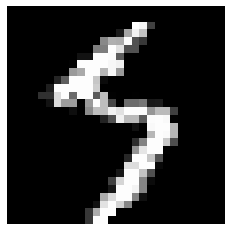

rotated 75


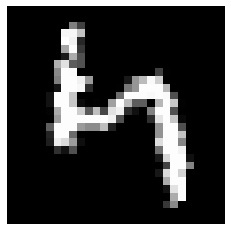

In [18]:
##################################################
#####. Design the experiment
##################################################

## 30 is unlabeled
## we test on 75

X_full = np.concatenate([X_train, X_train_15, X_train_30, X_train_45, X_train_60, X_train_75])
Y_full = np.concatenate([Y_train, Y_train_15, Y_train_30, Y_train_45, Y_train_60, Y_train_75])

print(X_full.shape)

### also create the condition label (degrees = label) 
n_train = Y_train.shape[0]
Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                              np.full(n_train, 2), np.full(n_train, 3),
                              np.full(n_train, 4), np.full(n_train, 5)], axis=0)
label_full = to_categorical(Label_full)


idx_train = np.where(np.logical_and(Label_full!=2, Label_full!=5))[0]
idx_30 = np.where(Label_full==2)[0]
idx_75 = np.where(Label_full==5)[0]

print("rotated 30")
plt.imshow(X_full[idx_30[0],].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print("rotated 75")
plt.imshow(X_full[idx_75[0]].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()


# for unknown proportions
X_unkp = X_full[idx_30,]
label_unkp = label_full[idx_30,]
y_unkp = Y_full[idx_30,]

# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
y_kp = Y_full[idx_train,]


# test
X_75 = X_full[idx_75,]
label_75 = label_full[idx_75,]
y_75 = Y_full[idx_75,]



# now take a subsample of the full dataset
unkp_size = 50000
kp_size = 50000
unkp_rand_idx = np.random.choice(X_unkp.shape[0], size=unkp_size, replace=False)
kp_rand_idx = np.random.choice(X_kp.shape[0], size=kp_size, replace=False)



Now train

In [19]:
# X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop
history = fit_model(X_unkp[unkp_rand_idx,:],
                    label_unkp[unkp_rand_idx,:],
                    X_kp[kp_rand_idx,:], 
                    y_kp[kp_rand_idx,:],
                    label_kp[kp_rand_idx,:], epochs=n_epoch)

print(X_75[0].shape) 
print(y_75[0].shape)


z_slack, mu_prop, z_rot = encoder.predict(X_75, batch_size=batch_size)
test_error = [mean_abs_error(mu_prop[idx], y_75[idx]) 
                  for idx in range(0, X_75.shape[1])]

print(f"mean test_error: {np.round(np.mean(test_error), decimals=3)}\n"
      f"median test_error: {np.round(np.median(test_error), decimals=3)}\n"
      f"max test_error: {np.round(np.max(test_error), decimals=3)}")




  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Elapsed:  1667.4703679084778
(784,)
(10,)
mean test_error: 0.3569999933242798
median test_error: 0.3479999899864197
max test_error: 1.0110000371932983


In [20]:
history

[[3039619.8,
  1845.5215,
  332.8583,
  3037441.2,
  [4018646.2, 2114.4646, 329.17673, 4016202.5]],
 [2656366.0,
  2392.9983,
  309.699,
  2653663.2,
  [2663759.8, 2813.9614, 328.803, 2660617.0]],
 [2960950.2,
  3849.862,
  291.6813,
  2956808.8,
  [1688473.0, 4545.0747, 330.93826, 1683597.0]],
 [3257383.0,
  5317.371,
  280.33804,
  3251785.2,
  [1287083.1, 6025.26, 331.52405, 1280726.4]],
 [3474847.2,
  6761.571,
  271.94238,
  3467813.8,
  [1110648.5, 7415.4204, 331.05325, 1102902.0]],
 [3442234.5,
  7612.216,
  266.30096,
  3434356.0,
  [1119592.8, 8279.029, 330.86487, 1110982.9]],
 [3308010.2,
  8420.981,
  266.26422,
  3299323.0,
  [1228419.5, 8908.912, 330.97833, 1219179.6]],
 [3035215.8,
  9090.857,
  262.11435,
  3025862.8,
  [1336355.0, 9067.031, 330.65656, 1326957.2]],
 [2924926.5,
  9761.593,
  253.84645,
  2914911.0,
  [1393551.1, 10262.263, 330.6181, 1382958.2]],
 [2797128.5,
  10417.534,
  251.87523,
  2786459.0,
  [1433707.1, 10756.322, 331.35992, 1422619.5]],
 [2704456

# **Inspect the output**

We will take two examples from our training and see how well it reconstructs.
We first look at the ground truth so we know what we should expect.

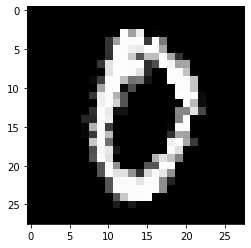

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0.]


In [21]:
plot_idx = 1

plt.imshow(X_unkp[plot_idx].reshape(28, 28), cmap = plt.cm.gray)
plt.show()
print(y_unkp[plot_idx])
print(label_unkp[plot_idx])


Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

In [22]:
plot_idx = 0

z_slack, mu_prop, z_rot = encoder.predict(X_full, batch_size=batch_size)
encoded_X0 = mu_prop[plot_idx]
rotated_vec = z_rot[plot_idx]
print(f"1-hot encoded condition vector: {Y_full[plot_idx]}\n")

print(f"output from encoder: {encoded_X0}")

encoded_X0[encoded_X0<0] = 0
print(f"output from encoder (ReLU applied): {encoded_X0}")

print(f"rotation: {label_full[plot_idx]}")
print(f"rotation (noReLU applied): {rotated_vec}")
rotated_vec[rotated_vec<0] = 0
print(f"rotation (ReLU applied): {rotated_vec}")

z_slack, mu_prop, z_rot = encoder.predict(X_full, batch_size=batch_size)
encoded_X0 = mu_prop[plot_idx]
rotated_vec = z_rot[plot_idx]

print(f"1-hot encoded condition vector: {Y_full[plot_idx]}")
print(f"output from encoder (no ReLU applied): {encoded_X0}")
encoded_X0[encoded_X0<0] = 0
print(f"output from encoder (ReLU applied): {encoded_X0}")

print(f"rotation: {label_full[200000+plot_idx]}")
print(f"output from encoder (noReLU applied): {rotated_vec}")
rotated_vec[rotated_vec<0] = 0
print(f"output from encoder (ReLU applied): {rotated_vec}")


1-hot encoded condition vector: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

output from encoder: [-0.05957008  0.2850426  -0.09106135  0.99320894 -0.24789408  1.4719795
 -0.85560447 -0.3832565  -0.4925166  -0.5028657 ]
output from encoder (ReLU applied): [0.         0.2850426  0.         0.99320894 0.         1.4719795
 0.         0.         0.         0.        ]
rotation: [1. 0. 0. 0. 0. 0.]
rotation (noReLU applied): [-1.10906649e+00  1.40536344e+00  1.01866198e+00 -2.09948793e-01
  1.11497924e-01 -4.80143756e-01 -5.95233977e-01 -8.34754169e-01
  7.42622018e-01  1.34818864e+00 -1.86184263e+00  3.67253989e-01
  9.99268293e-02 -7.64492095e-01 -9.15349782e-01 -2.02685618e+00
  1.53250027e+00  2.95491552e+00 -2.29086471e+00 -2.53603101e-01
 -1.42733008e-01 -4.86439347e-01  1.49085987e+00 -1.38710618e-01
  2.41742998e-01  3.46516907e-01 -1.70469284e+00  6.11476064e-01
 -3.06625509e+00  1.46366751e+00  1.22242999e+00  2.84272611e-01
 -1.27594447e+00 -1.21893930e+00  4.18937653e-02 -1.46742797e+00
 -

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.006s...
[t-SNE] Computed neighbors for 5000 samples in 0.653s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.358373
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.814636
[t-SNE] KL divergence after 300 iterations: 1.854511
t-SNE done! Time elapsed: 13.341679096221924 seconds
(5000, 2)
(5000, 2)


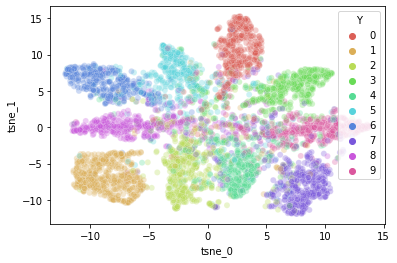

In [25]:
# plot proportions on ALL DATA
X_temp = X_full[idx_75,]

z_slack, mu_prop, z_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_75,]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 0.632s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.252264
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.508316
[t-SNE] KL divergence after 300 iterations: 1.687304
t-SNE done! Time elapsed: 12.977105617523193 seconds
(5000, 2)
(5000, 2)


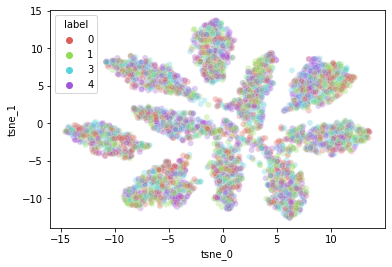

In [29]:
# plot proportions
X_temp = X_full[idx_train,]

z_slack, mu_prop, z_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.3
)




(5000, 2)
(5000, 2)


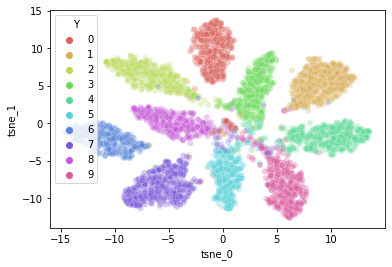

In [30]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)





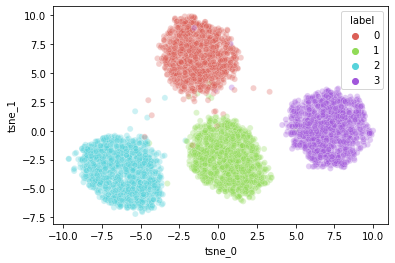

In [34]:
# plot rotation
z_test = z_rot
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full
plot_df['label'] = Label_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.3
)


(5000, 2)
(5000, 2)


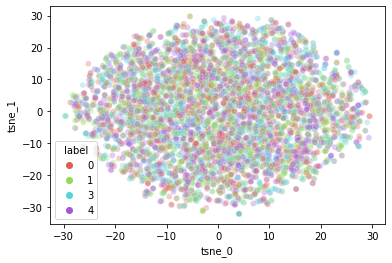

In [36]:
# plot remaining variance
z_test = z_slack
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.3
)


(5000, 2)
(5000, 2)


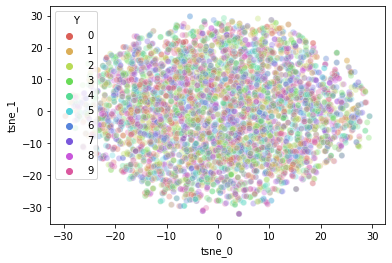

In [37]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)


In [ ]:

def method_sample_z(args):
    mu, l_sigma = args
    eps = np.random.normal(size=(batch_size, n_z), loc=0., scale=1.)
    return mu + np.exp(l_sigma / 2) * eps

def sample_digit(digit, X_test, Y_test, digit_scale):
  digit_idx = np.where(Y_test == digit)

  pred_input = X_test[digit_idx[0]]
  rand_idx = np.random.choice(pred_input.shape[0], size=batch_size, replace=False)
  pred_input = pred_input[rand_idx]

  test_X, test_mu, test_label, test_lsigma = known_prop_vae.predict(pred_input, batch_size=batch_size)

  encoded_X0 = np.ones(10)*0.0001
  encoded_X0[digit] = digit_scale
  rand_lsigma = np.random.random_integers(low = 0, high = 249)
  z_0_digit = method_sample_z([encoded_X0, test_lsigma])
  z_0_digit = z_0_digit[rand_lsigma].reshape((1,10))
  return(z_0_digit)

digit_img = 3

Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)

X_temp = X_full[idx_train,]

keep_rot_idx = np.where(Y_temp == digit_img)[0]
print(sum(keep_rot_idx))
X_example = X_temp[keep_rot_idx,]
z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

z_0_digit = sample_digit(digit_img, X_temp, Y_temp, 10)
plt.figure(figsize=(3, 3))

# it is rotated
rotate_1hot = np.zeros(n_label_z)

# slack, prop, rot
slack_sample = [0,0,0,0,0,0,0,0,0,0]
pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,n_label_z+n_z+n_z))

print(f"rotated {digit_img}")
plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

# it is rotated
rotate_1hot = np.zeros(n_label_z)
pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,n_label_z+n_z+n_z))

print(f"rotated {digit_img}")
plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

In [ ]:
img_it = 0
sides = 10
slack_sample = [0,0,0,0,0,0,0,0,0,0]
rotate_scale = 10.


Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)

X_temp = X_full[idx_train,]

rotate_1hot =  np.zeros(n_label_z)
for i in range(0, sides):
    for j in range(0, sides):
        z_0_digit = sample_digit(i, X_temp, Y_temp, 2**j)

        digit_img = i

        keep_rot_idx = np.where(Y_temp == digit_img)[0]
        X_example = X_temp[keep_rot_idx,]
        z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

        # slack, prop, rot
        slack_sample = z_slack[0]
        pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,n_label_z+n_z+n_z))

        decoded = decoder.predict(pred_input)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()


rotate_1hot = np.zeros(n_label_z)
img_it = 0
sides = 10
for i in range(0, sides):
    for j in range(0, 6):
        rotate_1hot = np.zeros(n_label_z)
        rotate_1hot[j] = alpha_rot
        z_0_digit = sample_digit(i, X_temp, Y_temp, 2**4)
        digit_img = i

        keep_rot_idx = np.where(Y_temp == digit_img)[0]
        X_example = X_temp[keep_rot_idx,]
        z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

        # slack, prop, rot
        slack_sample = z_slack[0]
        pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,n_label_z+n_z+n_z))

        decoded = decoder.predict(pred_input)
        subplot(sides, 6, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

In [ ]:
# predict rotated numbers

# normalizing the data to make the neural network easier to learn
x_train_r = normalize(X_train_r, axis=1)
x_test_r = normalize(X_test_r, axis=1)

#choosing the sequential model
classification_model = Sequential()

#defining the architecture of the model
X_class = Input(shape=(n_x,))
classification_model.add(X_class)
classification_model.add(Dense(512, activation='relu'))
classification_model.add(Dense(128, activation='relu'))
classification_model.add(Dense(10, activation='softmax'))

#defining the parameters to train the model
classification_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#training the model
classification_model.fit(x_train_r,Y_train_r,epochs=5)

In [ ]:

num_correct = 0
num_digits = 10
num_rep = 100
rotate_1hot = np.array([0., 10])
rotate_val = True
slack_sample = method_sample_z([0,1])[0]
acc = []
for digit_idx in range(0, num_digits):
  num_correct = 0
  for idx_rep in range(0, num_rep):
    z_0_digit = sample_digit(digit_idx, Y_test, 2**6, rotate=rotate_val)
    digit_img = digit_idx

    keep_rot_idx = Y_full_test[:,digit_img] > 0.7
    X_example = X_full_test[keep_rot_idx,]
    z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

    # slack, prop, rot
    slack_sample = z_slack[10]
    slack_sample = [0,0,0,0,0,0,0,0,0,0]
    pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))


    decoded = decoder.predict(pred_input)
    predictions = classification_model.predict(decoded)
    #print(f"true: {idx} pred: {np.argmax(predictions)}")
    if(digit_idx == np.argmax(predictions)):
      num_correct += 1
  acc = np.append(acc, num_correct)

print(np.mean(acc))
print(acc)

In [ ]:
digit_idx=1
for idx_rep in range(0, 10):
  z_0_digit = sample_digit(digit_idx, Y_test, 2**idx_rep, rotate=rotate_val)
  digit_img = digit_idx

  keep_rot_idx = Y_full_test[:,digit_img] > 0.9
  X_example = X_full_test[keep_rot_idx,]
  z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

  # slack, prop, rot
  slack_sample = [0,0,0,0,0,0,0,0,0,0]
  pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))

  print(f"rotated {digit_img}")
  plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
  plt.show()

